In [2]:
from __future__ import print_function
from __future__ import unicode_literals
import pynini
import re
from string import punctuation, ascii_letters

In [3]:
output_alphabet = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine","ten", 
                   "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen",
                   "eighteen", "nineteen", 
                   "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty","ninty", 
                   "hundred"]

input_alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

eps = '<eps>' # both input table and output table should include this

# HW2
## fst: Number-name generator

You will build a finite-state transducer that takes a number between 0 and 999 and turn it into words. For example, it will take 123 and produce "one hundred twenty three". Note that you will need to create a new symbol table for the output, which will contain words like "one" and "hundred". For the input, just use the ascii.syms.txt symbol table.

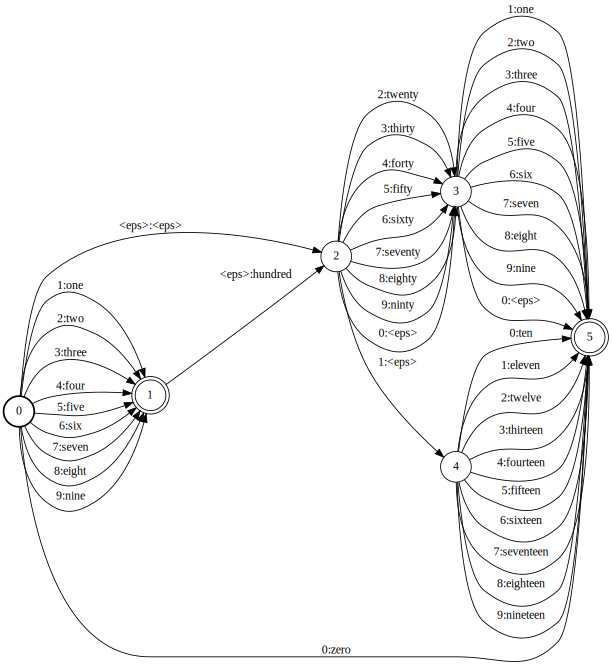

In [89]:
fst = pynini.Fst()
for _ in range(0,6):
    fst.add_state()
fst.set_start(0)
fst.set_final(5)
#fst.set_final(3)
fst.set_final(1)


input_table = pynini.SymbolTable()
output_table = pynini.SymbolTable()

input_table.add_symbol(eps, key=0)
output_table.add_symbol(eps, key=0)
output_table.add_symbol("offset") #How do you show two symbol tables with same index? (input, output)

for ch in input_alphabet:
    input_table.add_symbol(ch)
for ch in output_alphabet:
    output_table.add_symbol(ch)

fst.set_input_symbols(input_table)
fst.set_output_symbols(output_table)

#Add eps arcs
fst.add_arc(0, pynini.Arc(0, 0, 0, 2))
#fst.add_arc(1, pynini.Arc(0, 0, 0, 2))
#fst.add_arc(2, pynini.Arc(0, 0, 0, 3))

#Add single digit arcs
for i in range(1,10):
    fst.add_arc(3, pynini.Arc(input_table.find(input_alphabet[i]), output_table.find(output_alphabet[i]), 0, 5))
fst.add_arc(3, pynini.Arc(1, 0, 0, 5)) #0 to eps

#Add tens digit arcs
for i in range(2,10):
    fst.add_arc(2, pynini.Arc(input_table.find(input_alphabet[i]), output_table.find(output_alphabet[i+18]), 0, 3))
fst.add_arc(2, pynini.Arc(input_table.find(input_alphabet[0]), 0, 0, 3)) #0:eps case for 10_

#Add hundreds digit arcs
for i in range(1,10):
    fst.add_arc(0, pynini.Arc(input_table.find(input_alphabet[i]), output_table.find(output_alphabet[i]), 0, 1))
fst.add_arc(1, pynini.Arc(0, output_table.find(output_alphabet[28]), 0, 2)) #"hundred" label

#special teens cases
fst.add_arc(2, pynini.Arc(input_table.find(input_alphabet[1]), 0, 0, 4)) 
for i in range(0,10):
    fst.add_arc(4, pynini.Arc(input_table.find(input_alphabet[i]), output_table.find(output_alphabet[i+10]), 0, 5))
    
#special zero case
fst.add_arc(0, pynini.Arc(input_table.find(input_alphabet[0]), output_table.find(output_alphabet[0]), 0, 5))    
    
fst
#epsilon_machine = pynini.epsilon_machine()
#fst.union(epsilon_machine)

### Output Verification

In [94]:
for i in range(0,999):
    num = str(i)
    fst_acceptor = pynini.acceptor(" ".join(num), token_type = input_table)
    solution = pynini.compose(fst_acceptor, fst)
    ans = solution.stringify(token_type = output_table).replace("<eps>","").replace("  ", " ").strip()
    print(ans)


zero
one
two
three
four
five
six
seven
eight
nine
ten
eleven
twelve
thirteen
fourteen
fifteen
sixteen
seventeen
eighteen
nineteen
twenty
twenty one
twenty two
twenty three
twenty four
twenty five
twenty six
twenty seven
twenty eight
twenty nine
thirty
thirty one
thirty two
thirty three
thirty four
thirty five
thirty six
thirty seven
thirty eight
thirty nine
forty
forty one
forty two
forty three
forty four
forty five
forty six
forty seven
forty eight
forty nine
fifty
fifty one
fifty two
fifty three
fifty four
fifty five
fifty six
fifty seven
fifty eight
fifty nine
sixty
sixty one
sixty two
sixty three
sixty four
sixty five
sixty six
sixty seven
sixty eight
sixty nine
seventy
seventy one
seventy two
seventy three
seventy four
seventy five
seventy six
seventy seven
seventy eight
seventy nine
eighty
eighty one
eighty two
eighty three
eighty four
eighty five
eighty six
eighty seven
eighty eight
eighty nine
ninty
ninty one
ninty two
ninty three
ninty four
ninty five
ninty six
ninty seven
nin

seven hundred twenty
seven hundred twenty one
seven hundred twenty two
seven hundred twenty three
seven hundred twenty four
seven hundred twenty five
seven hundred twenty six
seven hundred twenty seven
seven hundred twenty eight
seven hundred twenty nine
seven hundred thirty
seven hundred thirty one
seven hundred thirty two
seven hundred thirty three
seven hundred thirty four
seven hundred thirty five
seven hundred thirty six
seven hundred thirty seven
seven hundred thirty eight
seven hundred thirty nine
seven hundred forty
seven hundred forty one
seven hundred forty two
seven hundred forty three
seven hundred forty four
seven hundred forty five
seven hundred forty six
seven hundred forty seven
seven hundred forty eight
seven hundred forty nine
seven hundred fifty
seven hundred fifty one
seven hundred fifty two
seven hundred fifty three
seven hundred fifty four
seven hundred fifty five
seven hundred fifty six
seven hundred fifty seven
seven hundred fifty eight
seven hundred fifty nine


The issues with a number-name translator that will need to be solved are as follows:

### #1. A digit is translated to a different word based on whether it's in the ones, tens, or hundreds place.

If we read left to right, it is difficult to deduce the tens-power until we reach the end of the string, but if we read backwards, we can figure that out as we go.
> Scrapped, had trouble with zero cases when starting with the ones place.

Instead, I learned this assignment that the input tape must be fully consumed, even if we are sitting on an output state, so looks like we can go left to right after all!

I am using two end states: one for digits 0-9 in state 1, and the second for all other numbers at the last state.

### #2. Special cases

#### 2.a Zero

Could add into my 0->1 transitions along with every other "ones" case, but that would allow translation for strings like "011" as "0 hundred eleven". Not the end of the world, but makes a good case for having zero as it's own special case.
    
#### 2.b Teens
    
Epsilon transitions can be used to consume multiple inputs for a single output (i.e. 11 -> eps eps eleven), as seen in the Tokenization example in the openfst docs: (http://www.openfst.org/twiki/bin/view/FST/FstExamples). We can easily remove the "eps" later with python string replacements.

These were sent off on a separate branch from the 20-99 branch as they are special cases.

### Conclusion
The output from 0-999 was printed in a loop and verified by eye. Some additional cases that required a small fix were the "10" and "100" cases, which needed a "zero:eps" transition for it to reach the end state.

<span style="color:red">Self Comments:</span>